In [14]:
%matplotlib inline

import inspect

## 0. Load data, filter

From preproc/preproc.py

In [15]:
from preproc.preproc import bandpass

print inspect.getsource(bandpass)

def bandpass(sig,band,fs):
    B,A = butter(5, array(band)/(fs/2), btype='bandpass')
    return lfilter(B, A, sig, axis=0)



In [16]:
from numpy import *
import numpy as np
import glob
import re
from pylab import *
from scipy.signal import *
import pandas as pd

In [17]:
reg = re.compile('\d+')

f = '/home/thomas/datasets/Data_S02_Sess01.csv'
user,session = reg.findall(f)
sig = np.array(pd.io.parsers.read_csv(f))

freq = 200.0
epoc_window = 1.3*freq

EEG = sig[:,1:-2]
EOG = sig[:,-2]
Trigger = sig[:,-1]
X = []

sigF = bandpass(EEG,[1.0,40.0],freq)
idxFeedBack = np.where(Trigger==1)[0]

In [18]:
for fbkNum,idx in enumerate(idxFeedBack):
    X.append(sigF[idx:idx+epoc_window,:])
    
X = array(X).transpose((0,2,1)) # Ns,Ne,Nt

/home/thomas/anaconda3/envs/vproject/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


(60, 56, 260)
#feedback, #sensor, time


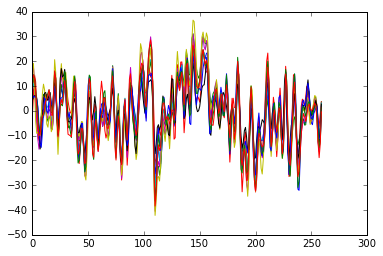

In [19]:
print X.shape
print '#feedback, #sensor, time'

# plotting the first feedback event for 10 sensors
plot(X[0,:10,:].transpose())
show()


## 1. Xdawn covariances

In [20]:
from classif import XdawnCovariances

print inspect.getsource(XdawnCovariances)

class XdawnCovariances(BaseEstimator,TransformerMixin):
    """ 
    Compute double xdawn, project the signal and compute the covariances

    """    
    def __init__(self,nfilter=4,subelec=-1):
        self.nfilter = nfilter
        self.subelec = subelec
        
    def fit(self,X,y):
        Nt,Ne,Ns = X.shape
        # Prototyped responce for each class
        P1 = numpy.mean(X[y==1,:,:],axis=0)
        P0 = numpy.mean(X[y==0,:,:],axis=0)
        
        # Covariance matrix of the prototyper response & signal
        C1 = numpy.matrix(numpy.cov(P1))
        C0 = numpy.matrix(numpy.cov(P0))
        
        #FIXME : too many reshape operation        
        tmp = X.transpose((1,2,0))
        Cx = numpy.matrix(numpy.cov(tmp.reshape(Ne,Ns*Nt)))
        
        # Spatial filters
        D,V1 = geig(C1,Cx)        
        D,V0 = geig(C0,Cx)
        
        # create the reduced prototyped response
        self.P = numpy.concatenate((numpy.dot(V1[:,0:self.nfilter].T,P1),numpy.dot(V

In [21]:
xd = XdawnCovariances(nfilter=5, subelec=range(0, 56, 1))

In [22]:
fake_target = np.random.randint(0, 2, size=(X.shape[0]))
print fake_target

[1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1]


In [23]:
output_xd = xd.fit_transform(X, fake_target)

In [24]:
print output_xd.shape

(60, 66, 66)


## 2. Electrode select

In [25]:
from classif import ElectrodeSelect

print inspect.getsource(ElectrodeSelect)

class ElectrodeSelect(BaseEstimator, TransformerMixin):

    def __init__(self,nelec = 20,nfilters=5,metric='riemann'):
        self.nelec = nelec
        self.metric = metric
        self.nfilters = nfilters
        self.subelec = -1
        self.dist = []
    
    def fit(self,X,y=None):
        C1 = riemann.mean_covariance(X[y==1,...],self.metric)
        C0 = riemann.mean_covariance(X[y==0,...],self.metric)
        
        Ne,_ = C0.shape
        
        self.subelec = range(0,Ne,1) 
        while (len(self.subelec)-2*self.nfilters)>self.nelec:
            di = numpy.zeros((len(self.subelec),1))
            for idx in range(2*self.nfilters,len(self.subelec)):
                sub = self.subelec[:]
                sub.pop(idx)
                di[idx] = riemann.distance(C0[:,sub][sub,:],C1[:,sub][sub,:])
            #print di
            torm = di.argmax()
            self.dist.append(di.max())
            self.subelec.pop(torm)        
        #print self.subelec
        
    def t

In [26]:
es = ElectrodeSelect(nfilters=5, nelec=35, metric='riemann')

In [27]:
es_output = es.fit_transform(output_xd, fake_target)

In [28]:
print es_output.shape

(60, 45, 45)


## 3. TangentSpace

In [29]:
from classif import TangentSpace
print inspect.getsource(TangentSpace)

class TangentSpace(BaseEstimator, TransformerMixin):

    def __init__(self,metric='riemann',tsupdate = False):

        self.metric = metric
        self.tsupdate = tsupdate 

        
    def fit(self,X,y=None):
        # compute mean covariance
        self.Cr = riemann.mean_covariance(X,metric=self.metric)
        
    def transform(self,X):
       
        if self.tsupdate:
            Cr = riemann.mean_covariance(X,metric=self.metric)
        else:
            Cr = self.Cr
        return riemann.tangent_space(X,Cr)

    def fit_transform(self,X,y=None):
        # compute mean covariance
        self.Cr = riemann.mean_covariance(X,metric=self.metric)
        return riemann.tangent_space(X,self.Cr)



In [30]:
ts = TangentSpace(metric='logeuclid', tsupdate=False)

ts_output = ts.fit_transform(es_output, fake_target)

In [31]:
print ts_output.shape

(60, 1035)


## 4. Normalizer

In [35]:
from sklearn.preprocessing import Normalizer

# print inspect.getsource(Normalizer)

In [37]:
normalizer = Normalizer(norm='l1')

norm_output = normalizer.fit_transform(ts_output, fake_target)

In [38]:
print norm_output.shape

(60, 1035)


## 5. AddMeta

## 6. ElasticNet

In [39]:
from sklearn.linear_model import ElasticNet

In [41]:
en = ElasticNet(l1_ratio=0.5, alpha=2e-4, normalize=True)

elastic_output = en.fit(norm_output, fake_target)

In [47]:
en.decision_function(norm_output)

/home/thomas/anaconda3/envs/vproject/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


array([  9.94645123e-01,   2.83041469e-03,   4.06643044e-03,
         9.96135361e-01,   9.96806854e-01,   9.95452776e-01,
         9.96549904e-01,   5.32152991e-03,   6.76657065e-03,
         4.54745187e-03,   9.96302385e-01,   1.40164597e-03,
         9.94098106e-01,   3.50754589e-03,   9.99682264e-01,
         2.14780470e-04,   2.29536811e-03,   3.10266629e-03,
         3.13006075e-03,   3.08120630e-03,   9.97137387e-01,
         2.42618539e-03,   9.75833639e-05,   4.38871888e-03,
         9.98944781e-01,   9.96169724e-01,   9.96329075e-01,
         5.11467846e-03,   9.98726381e-01,   9.98175232e-01,
         1.55824336e-03,  -8.07494360e-06,   5.26343687e-03,
        -1.91658520e-03,   2.71859086e-03,   9.95864410e-01,
         9.97508484e-01,   9.97754339e-01,   3.16905119e-03,
         9.94614835e-01,   9.94705925e-01,   9.02297200e-04,
         3.38707674e-03,   2.82253387e-03,   3.28740010e-03,
         9.95451273e-01,   1.49075301e-03,   2.61396959e-03,
         9.96959892e-01,

# décomposition

In [57]:
# step by step xdawn
Nt,Ne,Ns = X.shape

P1 = np.mean(X[fake_target==1,:,:],axis=0)
P0 = np.mean(X[fake_target==0,:,:],axis=0)

print 'shapes for P0, P1', P0.shape, P1.shape
# sensor #, timestep

C1 = np.matrix(np.cov(P1))
C0 = np.matrix(np.cov(P0))

print 'shapes for C0, C1',  C0.shape, C1.shape

tmp = X.transpose((1,2,0))
Cx = np.matrix(np.cov(tmp.reshape(Ne,Ns*Nt)))

print 'shape for Cx', Cx.shape

shapes for P0, P1 (56, 260) (56, 260)
shapes for C0, C1 (56, 56) (56, 56)
shape for Cx (56, 56)


In [66]:
from scipy.linalg import eig as geig

D,V1 = geig(C1,Cx)        
D,V0 = geig(C0,Cx)
# V0, V1 contiennent les vecteurs propres
print 'shape for D, V1', D.shape, V1.shape

shape for D, V1 (56,) (56, 56)


In [67]:
nfilter=5

dot1 = np.dot(V1[:,0:nfilter].T,P1)
dot0 = np.dot(V0[:,0:nfilter].T,P0)

P = np.concatenate((dot1, dot0),axis=0)

print 'shape for self.P', P.shape

shape for self.P (10, 260)


In [68]:
# puis au moment de faire transform
import riemann

subelec = range(0,56,1)
covmats = riemann.covariances_EP(X[:,subelec,:],P)

In [69]:
print covmats.shape

(60, 66, 66)
